#### Lemon quality detection

In [85]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [86]:
image_size = 300
batch_size = 32

In [87]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    seed = 123,
    shuffle = True,
    batch_size = batch_size,
    image_size=(image_size, image_size)
)

Found 2528 files belonging to 3 classes.


In [88]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [89]:
class_names = dataset.class_names

In [90]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(image_batch.numpy())

(32, 300, 300, 3)
[[[[157. 160. 153.]
   [160. 163. 156.]
   [166. 169. 162.]
   ...
   [104.  97.  87.]
   [102.  95.  85.]
   [ 96.  89.  79.]]

  [[164. 167. 160.]
   [171. 174. 167.]
   [169. 172. 165.]
   ...
   [105.  98.  88.]
   [ 93.  86.  76.]
   [ 69.  62.  52.]]

  [[176. 179. 172.]
   [177. 180. 173.]
   [176. 179. 172.]
   ...
   [102.  95.  85.]
   [ 93.  86.  76.]
   [ 69.  62.  52.]]

  ...

  [[204. 205. 200.]
   [207. 208. 203.]
   [211. 213. 208.]
   ...
   [ 89.  90.  82.]
   [ 97.  98.  90.]
   [118. 119. 111.]]

  [[207. 208. 203.]
   [207. 208. 203.]
   [208. 210. 205.]
   ...
   [ 79.  80.  72.]
   [ 93.  94.  86.]
   [116. 117. 109.]]

  [[206. 207. 202.]
   [203. 204. 199.]
   [202. 204. 199.]
   ...
   [ 80.  81.  73.]
   [102. 103.  95.]
   [119. 120. 112.]]]


 [[[ 93.  91.  79.]
   [ 91.  89.  77.]
   [ 90.  88.  76.]
   ...
   [151. 153. 148.]
   [157. 159. 154.]
   [162. 164. 159.]]

  [[ 92.  90.  78.]
   [ 90.  88.  76.]
   [ 89.  87.  75.]
   ...
   

In [91]:
len(dataset)

79

In [92]:
79*32

2528

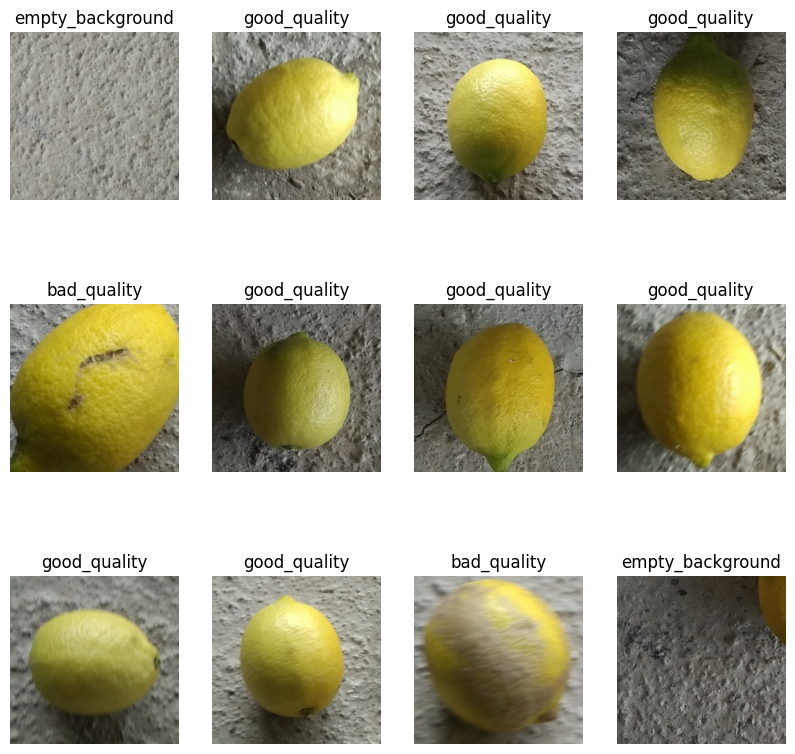

In [93]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [94]:
def split_dataset(dataset, train_split=0.8, test_split=0.1, val_split=0.1, shuffle=True, shuffle_size= 10000):
    assert (train_split+ test_split + val_split) == 1
    
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
        
    train_size = int(ds_size*train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = dataset.take(train_size)
    val_ds = dataset.skip(train_size).take(val_size)
    test_ds = dataset.skip(train_size).skip(val_size)
    
    return train_ds, test_ds, val_ds

In [95]:
train_ds, test_ds, val_ds = split_dataset(dataset)

In [96]:
len(train_ds)

63

In [97]:
len(test_ds)

9

In [98]:
len(val_ds)

7

In [99]:
# cache, shuffle, prefatche the dataset
train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [100]:
# model building

In [101]:
from tensorflow.keras.layers import Rescaling, Resizing, RandomFlip, RandomRotation, Conv2D, MaxPooling2D, Flatten, Dense

resize_and_rescale = tf.keras.Sequential([
    Resizing(image_size, image_size),
    Rescaling(1./299),
])

In [102]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal_and_vertical"),
    RandomRotation(0.2),
])

In [103]:
# apply data augmentation  in train_ds

In [104]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [105]:
# model architecture

In [106]:
channel = 3
n_classes = 3

In [107]:
resize_and_rescale

<Sequential name=sequential_17, built=False>

In [109]:
input_shape = (batch_size, image_size, image_size, channel)

In [110]:
input_shape

(32, 300, 300, 3)

In [113]:
input_shape = (image_size, image_size, channel)
model = models.Sequential([
    tf.keras.Input(shape=input_shape),
    resize_and_rescale,
    Conv2D(32, kernel_size=(3,3), activation = "relu", input_shape = input_shape),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3,3), activation = "relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, kernel_size=(3,3), activation = "relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation = "relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation="relu"),
    Dense(n_classes, activation="softmax"),
])

In [117]:
model.build(input_shape = (None,image_size, image_size, channel))

In [118]:
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_17 (Sequential)      │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 298, 298, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 149, 149, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 147, 147, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 71, 71, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [120]:
# compile our model
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [121]:
history = model.fit(
    train_ds,
    batch_size = batch_size,
    validation_data = val_ds,
    verbose=1,
    epochs=30
)

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 168s 2s/step - accuracy: 0.5263 - loss: 0.8559 - val_accuracy: 0.8214 - val_loss: 0.3887
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 166s 3s/step - accuracy: 0.7988 - loss: 0.4324 - val_accuracy: 0.8348 - val_loss: 0.3752
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 176s 3s/step - accuracy: 0.8074 - loss: 0.4249 - val_accuracy: 0.8571 - val_loss: 0.2989
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.8772 - loss: 0.2775 - val_accuracy: 0.9286 - val_loss: 0.2329
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 177s 3s/step - accuracy: 0.9229 - loss: 0.2039 - val_accuracy: 0.9688 - val_loss: 0.1104
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 181s 3s/step - accuracy: 0.9448 - loss: 0.1388 - val_accuracy: 0.9241 - val_loss: 0.1720
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 160s 2s/step - accuracy: 0.9335 - loss: 0.1721 - val_accuracy: 0.8705 - val_loss: 0.4291
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - accuracy: 0.9211 - loss: 0.2625 - val_accuracy: 0.9777 - v